# LBA
### Gelana Tostaeva

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import pystan

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.2)
sns.set_palette("Paired")

## Preprocessing

In [90]:
""" Loading the dataset  """

#Loading the partially processed data and subsetting/dropping columns for further use
data = pd.read_csv('lba_data.csv')
meta_data = data.drop(['Your name'], axis=1)
store_data = data.drop(['Your name', 'Grocery store', 'Neighborhood'], axis=1)
products = ["apples", "bananas", "tomatoes", "potatoes", "flour", "rice", "milk", "butter", "eggs", "chicken"]

#Fixing for reproducibility just in case
np.random.seed(0)

meta_data.head()

,Grocery store,Neighborhood,Apples,Price,Apples.1,Price.1,Apples.2,Price.2,Bananas\t\t\t\t\t,Price.3,...,Eggs.1,Price.25,Eggs.2,Price.26,Chicken,Price.27,Chicken.1,Price.28,Chicken.2,Price.29
0,ALDI,Alt-Treptow,1.00,2.86,1.0,1.49,1.0,1.79,1.0,1.69,...,1.0,0.16,1.0,0.20,1.00,5.99,1.0,6.65,NaN,NaN
1,ALDI,Friedrichshain,1.00,1.39,2.0,2.29,1.0,1.79,1.0,1.15,...,10.0,1.69,10.0,1.19,0.60,3.99,1.0,5.99,NaN,NaN
2,ALDI,Kreuzberg,0.60,1.95,2.0,2.29,1.0,1.39,1.0,1.69,...,10.0,1.19,6.0,1.59,0.35,2.99,0.6,3.99,1.0,5.99
3,ALDI,Lichtenberg,1.00,1.50,1.0,1.69,1.0,2.20,1.0,1.09,...,10.0,2.65,NaN,NaN,0.40,2.79,1.0,5.44,1.0,5.86
4,ALDI,Lichtenberg,0.88,2.20,1.0,1.88,0.6,1.89,1.0,1.69,...,6.0,1.59,10.0,1.59,0.60,3.99,1.0,5.99,NaN,NaN


In [91]:
""" Preprocessing the dataset  """

#Creating a dataframe with products as rows instead of columns 
#This is so we can easily encode later

df = []
#Going through all the rows
for i, r in meta_data.iterrows():
    store = r[0]
    neighborhood = r[1]

    #Going through the 62 columns starting with 'Apples'
    for c in range(2, 62, 2): 
        product = list(meta_data)[c]
        quantity = r[c]
        price = r[c+1]

        data_point = [product, quantity, price, store, neighborhood]
        df.append(data_point)
       
    
df = pd.DataFrame(df, columns = ['product','quantity','price','store','neighborhood'])
df['product'] = df['product'].str.replace("[^A-Za-z]+", "")

#Getting rid of any capitalization for consistency
for c in ['product', 'store', 'neighborhood']:
    df[c] = df[c].str.lower()

#Dropping null quantity and price values 
df.dropna(subset=['quantity', 'price'], inplace=True) #from 2430 to 2175 
#Normalizing the prices by dividing the price by corresponding quantity value
df['scaled'] = df['price']/df['quantity']
df.head()

,product,quantity,price,store,neighborhood,scaled
0,apples,1.0,2.86,aldi,alt-treptow,2.86
1,apples,1.0,1.49,aldi,alt-treptow,1.49
2,apples,1.0,1.79,aldi,alt-treptow,1.79
3,bananas,1.0,1.69,aldi,alt-treptow,1.69
4,bananas,1.0,0.99,aldi,alt-treptow,0.99


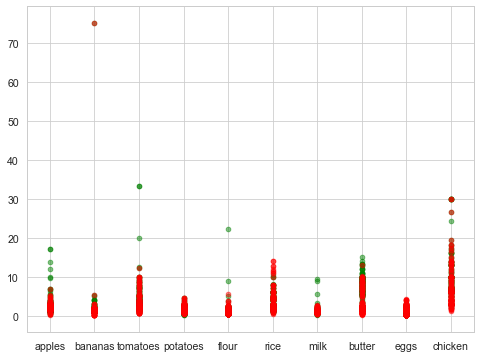

In [92]:
""" Visualizing the dataset  """

#Plotting the original vs normalized price values for each product 
#Noting the discussed outlier for the original prices of bananas 
#We can also see what looks like an outlier for the scaled price of tomatoes
plt.figure(figsize=(8,6))
plt.scatter(df['product'], df['scaled'],
            color='green', alpha=0.5)
plt.scatter(df['product'], df['price'],
            color='red', alpha=0.5)

In [93]:
""" Cleaning the dataset from outliers identified"""
#Dropping the bananas outlier
#While this might not be the best way to remove outliers, since we are only removing one
#maximum value, it works in this case
df.drop(df['price'].idxmax(), inplace=True) 
df['price'].max()


30.0

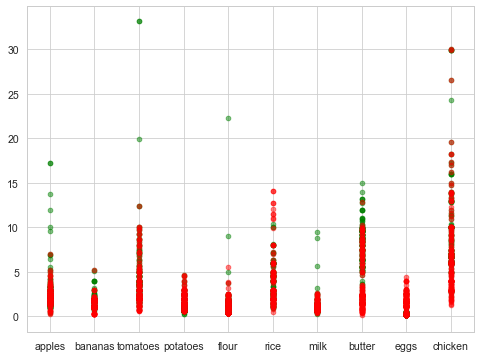

In [94]:
""" Visualizing the cleaned dataset  """

#Plotting the original vs normalized price values for each product 
#Noting the bananas outlier is no longer present
plt.figure(figsize=(8,6))
plt.scatter(df['product'], df['scaled'],
            color='green', alpha=0.5)
plt.scatter(df['product'], df['price'],
            color='red', alpha=0.5)

In [95]:
""" Encoding the dataset into numerical values """

encoding = dict()
for c in ['product', 'store', 'neighborhood']:
    encoding[c] = dict(enumerate(df[c].astype('category').cat.categories, 1))

#Printing the dictionary for reference
print(encoding) 

#Creating a copy in case we want to compare to the original dataset
enc_df = df.copy()

#Applying the encoding 
for c in ['product', 'store', 'neighborhood']:
    enc_df[c] = enc_df[c].astype('category').cat.codes+1
    
enc_df.head()

{'product': {1: 'apples', 2: 'bananas', 3: 'butter', 4: 'chicken', 5: 'eggs', 6: 'flour', 7: 'milk', 8: 'potatoes', 9: 'rice', 10: 'tomatoes'}, 'store': {1: 'aldi', 2: 'edeka', 3: 'lidl', 4: 'rewe', 5: "sainsbury's ", 6: 'tesco', 7: 'waitrose'}, 'neighborhood': {1: 'alt-treptow', 2: 'camden', 3: 'city', 4: 'friedrichshain', 5: 'hackney', 6: 'haringey', 7: 'islington', 8: 'kreuzberg', 9: 'lichtenberg', 10: 'mitte', 11: 'neukölln', 12: 'prenzlauer berg', 13: 'schöneberg', 14: 'southwark', 15: 'tempelhof', 16: 'westminster'}}


,product,quantity,price,store,neighborhood,scaled
0,1,1.0,2.86,1,1,2.86
1,1,1.0,1.49,1,1,1.49
2,1,1.0,1.79,1,1,1.79
3,2,1.0,1.69,1,1,1.69
4,2,1.0,0.99,1,1,0.99


## Modeling

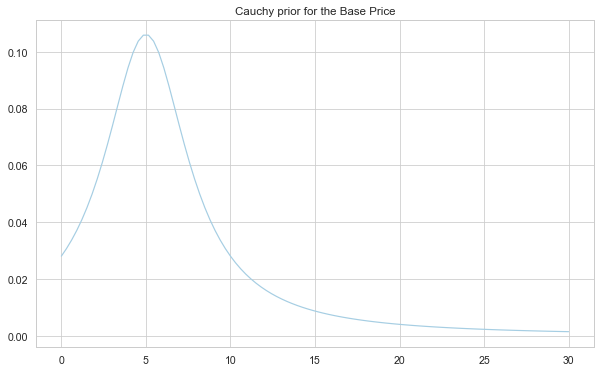

In [98]:
""" Choosing priors """

#Plotting the cauchy prior for the base prices assuming most products cost around 5 Euros,
#but with a lot of variation 
plt.figure(figsize=(10,6))
x = np.linspace(0,30,100)
plt.plot(x, stats.cauchy.pdf(x,loc=5,scale=3))
plt.title("Cauchy prior for the Base Price")
plt.show()

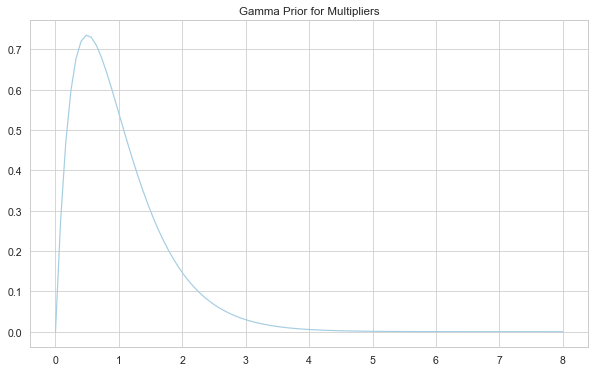

In [97]:
#Plotting the gamma prior for the multipliers assuming these are in the 0-8 range,
#but centered around 1 
plt.figure(figsize=(10,6))
x = np.linspace(0,8,100)
plt.plot(x, stats.gamma.pdf(x, a=2, scale=0.5))
plt.title("Gamma Prior for Multipliers")
plt.show()

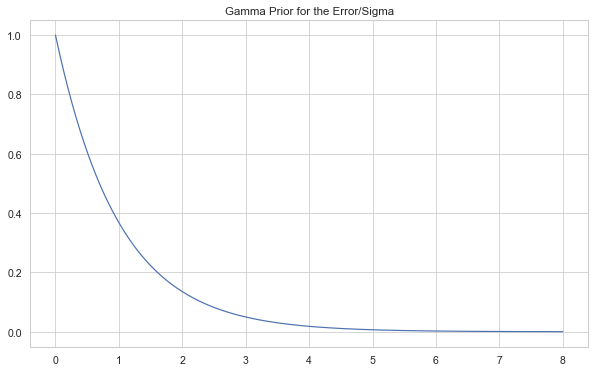

In [42]:
#Plotting the gamma prior for the error term as a hyperparameter sigma
#assuming it is the same for all products
plt.figure(figsize=(10,6))
x = np.linspace(0, 8, 500)
plt.plot(x, stats.gamma.pdf(x, a=1, scale=1))
plt.title("Gamma Prior for the Error/Sigma")
plt.show()

In [99]:
""" Defining the data for Stan, including both the observed data and prior hyperparameters 
num of data/products/stores/neighborhoods - the int number of datapoints/products/stores/
neighborhoods;
prices/products/stores/neighborhoods - the list of encoded prices/products/stores/
neighborhoods
alpha & beta - fixed hyperparameters for the gamma multiplier prior
"""

model_data = {
    'num_data' : len(enc_df),
    'num_products': len(set(enc_df['product'])),
    'num_stores' : len(set(enc_df['store'])),
    'num_neighborhoods': len(set(enc_df['neighborhood'])),
    
    'prices' : enc_df['scaled'].values,
    'products' : enc_df['product'].values,
    'stores' : enc_df['store'].values,
    'neighborhoods' : enc_df['neighborhood'].values,

    'alpha': 2,
    'beta': 0.5}

print(model_data)

{'num_data': 2174, 'num_products': 10, 'num_stores': 7, 'num_neighborhoods': 16, 'prices': array([ 2.86      ,  1.49      ,  1.79      , ...,  9.15555556,
       11.33333333, 16.        ]), 'products': array([1, 1, 1, ..., 4, 4, 4], dtype=int8), 'stores': array([1, 1, 1, ..., 7, 7, 7], dtype=int8), 'neighborhoods': array([1, 1, 1, ..., 7, 7, 7], dtype=int8), 'alpha': 2, 'beta': 0.5}


In [108]:
""" Defining the data, parameters, and model block: we need to specify what data to expect, 
the parameters we are using, and the prior and likelihood. 
"""

stan_code = """
data {
    int<lower=0> num_data;  // number of data points
    int<lower=0> num_products;  // number of products
    int<lower=0> num_stores;  // number of stores
    int<lower=0> num_neighborhoods;  // number of neighborhoods

    real<lower=0> prices[num_data];  // total prices
    int<lower=1> products[num_data]; // total products
    int<lower=1> stores[num_data];  // total stores
    int<lower=1> neighborhoods[num_data];  // total neighborhoods
    
    real<lower=0> alpha;  // prior hyperparameter for gamma
    real<lower=0> beta;  // prior hyperparameter for gamma
}

parameters {
    real<lower=0> base_price[num_products];  // base price vector           
    real<lower=0> store_m[num_stores];  // store multipliers vector
    real<lower=0> loc_m[num_neighborhoods];  // location multipliers vector
    real<lower=0> sigma; // standard deviation for the likelihood
}


model {
    // priors for the base price and multipliers
    base_price ~ cauchy(5, 3);
    store_m ~ gamma(alpha, beta);
    loc_m ~ gamma(alpha, beta);
    sigma ~ gamma(1,1);
    
    // model
    for (i in 1:num_data) {   
        prices[i] ~ normal(base_price[products[i]]*store_m[stores[i]]*loc_m[neighborhoods[i]], sigma);
        }    
}

"""

In [109]:
""" Compiling the Stan model """
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc963950adc02f980f1736479550194e NOW.


In [110]:
""" Fitting the model to the data and printing results for our parameters """
stan_results = stan_model.sampling(data=model_data)
samples = stan_results.extract()
print(stan_results)

Inference for Stan model: anon_model_bc963950adc02f980f1736479550194e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]    1.88    0.02   0.71   0.74    1.4    1.8   2.25   3.58    954    1.0
base_price[2]    1.11    0.01   0.43   0.42   0.81   1.06   1.33   2.12   1000    1.0
base_price[3]    5.22    0.06   1.94   2.02   3.93   5.01   6.25   9.74    952    1.0
base_price[4]    6.56    0.08   2.44   2.56   4.95    6.3   7.81  12.25    954    1.0
base_price[5]     0.2  3.4e-3   0.13   0.02   0.11   0.18   0.27   0.52   1452    1.0
base_price[6]    0.86    0.01   0.34   0.33   0.63   0.81   1.05   1.69   1053    1.0
base_price[7]    0.77  9.6e-3   0.31   0.29   0.56   0.73   0.93    1.5   1039    1.0
base_price[8]     0.9    0.01   0.36   0.33   0.66   0.86   1.08   1.78   1015    1.0
base_price[9]    2.44    0.03   0.91 

## Results

In [111]:
#Creating a function to visualize results
def visualize_results(category, parameter, ylim, rotation):
    plt.figure(figsize=(12, 6))
    for i in range(len(set(enc_df[category]))):
        plt.plot(stats.uniform.rvs(loc=i+1-0.2, scale=0.4, size=4000), samples[parameter][:,i], ',', alpha=0.5)

    plt.plot(range(1, len(set(enc_df[category])) + 1),
             samples[parameter].mean(axis=0), linewidth=0,
             marker = '*', color="black", alpha=0.8, markersize=5)     

    plt.xticks(range(1, len(set(enc_df[category])) + 1),
               list(encoding[category].values()), rotation=rotation)
    plt.title('Samples of posterior distributions of {}'.format(parameter))
    plt.ylim(0, ylim)
    plt.show()

    

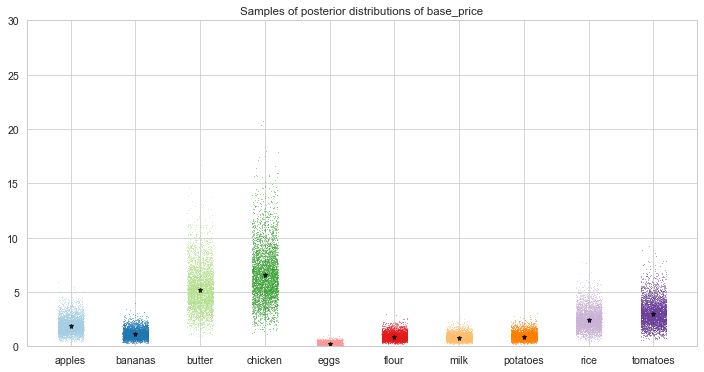

In [112]:
""" Plotting posterior distribution on the base price """
visualize_results('product', 'base_price', 30, None)

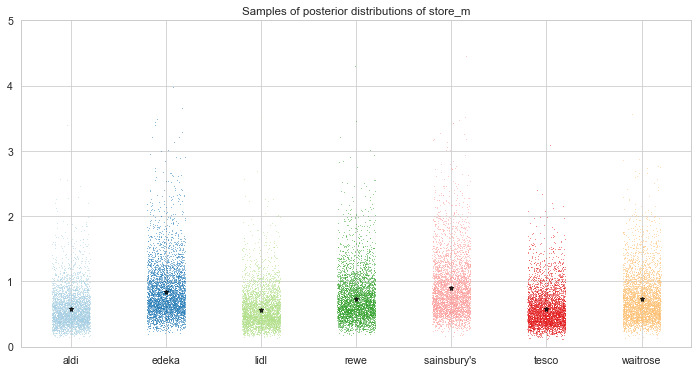

In [113]:
""" Plotting posterior distribution on the store multiplier """
visualize_results('store', 'store_m', 5, None)

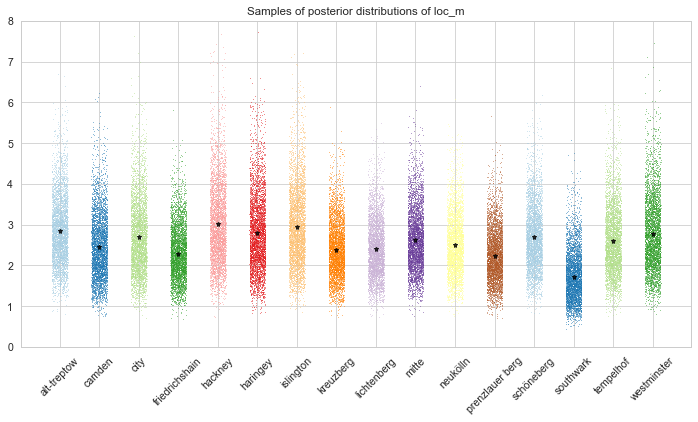

In [114]:
""" Plotting posterior distribution on the location multiplier """
visualize_results('neighborhood', 'loc_m', 8, 45)

Correlation coefficient for all: 0.03 with p-value of 0.518


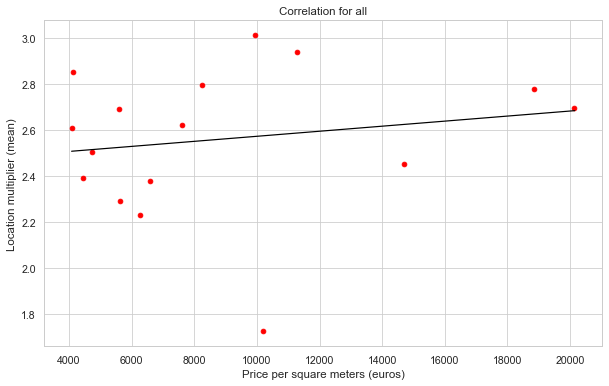

Correlation coefficient for Berlin: 0.162 with p-value of 0.283


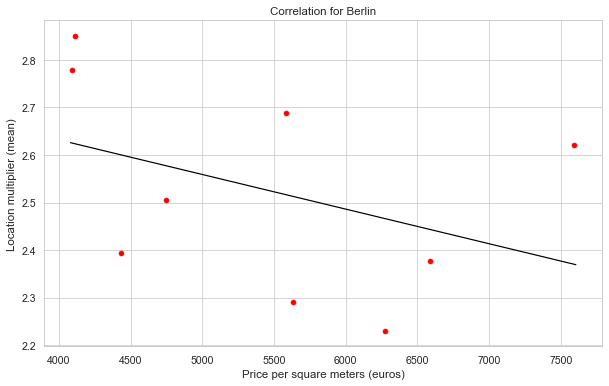

Correlation coefficient for London: 0.0 with p-value of 0.977


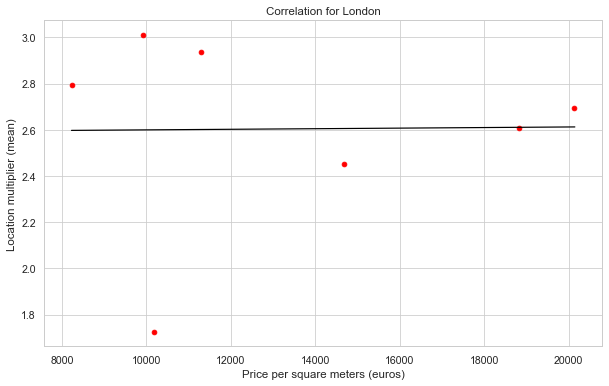

In [115]:
""" Determining correlation between property price and grocery store price """

#Creating lists of relevant prices
all_prices = [4110, 14690, 20139, 5635, 9929, 8233, 11281, 6590, 4435, 7595, 4745, 6275, 5585, 10182, 4090, 18835]
berlin = [4110, 5635, 6590, 4435, 7595, 4745, 6275, 5585, 4090]
london = [14690, 20139, 9929, 8233, 11281, 10182, 18835]

#Getting the relevant location multipliers
all_loc_m = samples['loc_m'].mean(axis=0)
london_loc_m = [all_loc_m[i] for i in [1,2,4,5,6,13,14]]
berlin_loc_m = list()
for _ in all_loc_m.tolist():
    if _ not in london_loc_m:
        berlin_loc_m.append(_)


#Creating a function to do regression and visualize results        
def regression_plot(prices, multipliers, name):
    plt.figure(figsize=(10,6))
    slope, intercept, r_value, p_value, std_err = stats.linregress(prices, multipliers)
    x = np.linspace(min(prices)-10, max(prices)+10, 100)
    plt.plot(x, slope*x + intercept, color='black')
    plt.scatter(prices, multipliers, color='red')
    plt.title("Correlation for {}".format(name))
    plt.xlabel("Price per square meters (euros)")
    plt.ylabel("Location multiplier (mean)")
    print("Correlation coefficient for {}: {} with p-value of {}".format(name, round(r_value**2,3), round(p_value,3)))
    plt.show()
    
    
regression_plot(all_prices, all_loc_m, 'all')
regression_plot(berlin, berlin_loc_m, 'Berlin')
regression_plot(london, london_loc_m, 'London')



